In [1]:
x=1

In [2]:
import scanpy as sc
import pandas as pd

In [3]:
patient = 'donor_id'
condition = 'lung_condition_coarse'
n_splits = 5

In [4]:
adata = sc.read('/lustre/groups/ml01/projects/2022_multigrate_anastasia.litinetskaya/snakemake/hlca/5fold/hlca_hyperparam/data/pp/hlca_hvg_pearson.h5ad')
adata

AnnData object with n_obs × n_vars = 2149684 × 2000
    obs: "3'_or_5'", 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ancestry', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'assay', 'cause_of_death', 'cell_type', 'core_or_extension', 'dataset', 'development_stage', 'disease', 'donor_id', 'fresh_or_frozen', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'original_ann_nonharmonized', 'reannotation_type', 'sample', 'scanvi_label', 'sequencing_platform', 'sex', 'smoking_status', 'study', 'subject_type', 'suspension_type', 'tissue', 'tissue_coarse_unharmonized', 'tissue_detailed_unharmonized', 'tissue_dissociation_protocol', 'tissue_level_2', 'tissue_level_3', 'tissue_sampling_method', 'total_counts', 'transf_ann_level_1_label', 'transf_ann_l

In [5]:
adata.X.data

array([1., 5., 1., ..., 1., 2., 3.], dtype=float32)

In [6]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# NN

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from math import ceil
from sklearn.preprocessing import label_binarize

In [8]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


In [9]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_out(x)
        
        return x

In [10]:
EPOCHS = 30
BATCH_SIZE = 512
LEARNING_RATE = 0.0001
NUM_FEATURES = len(adata.var_names)
NUM_CLASSES = len(adata.obs[condition].cat.categories)

In [11]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

Split 0...
Train shape = ((1927192, 2000), (1927192,)).
Val shape = ((812942, 2000), (812942,)).
Begin training.


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 030: | Train Loss: 0.02980 | Val Loss: 0.10472 | Train Acc: 99.108| Val Acc: 96.759
class report
              precision    recall  f1-score        support
0              0.626151  0.692464  0.657640     982.000000
1              0.879280  0.747398  0.807993   27862.000000
2              0.944007  0.967701  0.955707   76256.000000
3              0.975442  0.989577  0.982458    7867.000000
4              0.975516  0.981647  0.978572  523466.000000
5              0.611290  0.987106  0.755017   23421.000000
6              0.906229  0.742935  0.816497   93412.000000
7              0.964870  0.987757  0.976179   54806.000000
8              0.673529  0.658316  0.665836    4870.000000
accuracy       0.943241  0.943241  0.943241       0.943241
macro avg      0.839591  0.861656  0.843989  812942.000000
weighted avg   0.947858  0.943241  0.943132  812942.000000
Accuracy on the test set = 0.9432407232004251.
Split 1...
Train shape = ((1952712, 2000), (1952712,)).
Val shape = ((786898, 2000)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 030: | Train Loss: 0.03066 | Val Loss: 0.10602 | Train Acc: 99.073| Val Acc: 96.732
class report
              precision    recall  f1-score        support
0              0.694098  0.863495  0.769585    1934.000000
1              0.770393  0.844715  0.805844   16782.000000
2              0.977453  0.984027  0.980729  116570.000000
3              0.765522  0.983600  0.860966    4939.000000
4              0.978658  0.968172  0.973387  504520.000000
5              0.929436  0.467985  0.622521   28877.000000
6              0.722323  0.907767  0.804496   55739.000000
7              0.963695  0.972228  0.967942   57035.000000
8              0.196864  0.450199  0.273939     502.000000
accuracy       0.945056  0.945056  0.945056       0.945056
macro avg      0.777605  0.826910  0.784379  786898.000000
weighted avg   0.950454  0.945056  0.944015  786898.000000
Accuracy on the test set = 0.9450564113773322.
Split 2...
Train shape = ((1887295, 2000), (1887295,)).
Val shape = ((890391, 2000)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 030: | Train Loss: 0.03103 | Val Loss: 0.10742 | Train Acc: 99.065| Val Acc: 96.684
class report
              precision    recall  f1-score        support
0              0.863448  0.469045  0.607877    7091.000000
1              0.561014  0.806162  0.661610    5680.000000
2              0.954659  0.965720  0.960158  145509.000000
3              0.987572  0.834143  0.904396    7621.000000
4              0.973128  0.972232  0.972680  552790.000000
5              0.830651  0.584502  0.686169   25964.000000
6              0.783776  0.894805  0.835618   63349.000000
7              0.978341  0.994192  0.986203   74557.000000
8              0.701769  0.547254  0.614954    7830.000000
accuracy       0.946206  0.946206  0.946206       0.946206
macro avg      0.848262  0.785339  0.803296  890391.000000
weighted avg   0.947154  0.946206  0.945039  890391.000000
Accuracy on the test set = 0.9462056557175443.
Split 3...
Train shape = ((1937234, 2000), (1937234,)).
Val shape = ((793562, 2000)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 030: | Train Loss: 0.03181 | Val Loss: 0.10906 | Train Acc: 99.014| Val Acc: 96.625
class report
              precision    recall  f1-score        support
0              0.589392  0.688842  0.635248    3307.000000
1              0.826815  0.764832  0.794617   21423.000000
2              0.965686  0.972244  0.968954  104265.000000
3              0.722308  0.981319  0.832124    7655.000000
4              0.977615  0.960551  0.969008  492174.000000
5              0.839771  0.864609  0.852009   20319.000000
6              0.820153  0.890041  0.853669   60977.000000
7              0.968212  0.986976  0.977504   79928.000000
8              0.518692  0.347467  0.416155    3514.000000
accuracy       0.947944  0.947944  0.947944       0.947944
macro avg      0.803183  0.828542  0.811032  793562.000000
weighted avg   0.949288  0.947944  0.948131  793562.000000
Accuracy on the test set = 0.9479435759272747.
Split 4...
Train shape = ((1885690, 2000), (1885690,)).
Val shape = ((793795, 2000)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 030: | Train Loss: 0.03232 | Val Loss: 0.10772 | Train Acc: 98.997| Val Acc: 96.631
class report
              precision    recall  f1-score        support
0              0.786337  0.388185  0.519776    4181.000000
1              0.896120  0.744894  0.813539   16989.000000
2              0.943260  0.986568  0.964428  138697.000000
3              0.996136  0.981596  0.988813   12606.000000
4              0.959792  0.974379  0.967031  482303.000000
5              0.877435  0.812972  0.843975   19056.000000
6              0.718930  0.749010  0.733662   41157.000000
7              0.974827  0.927781  0.950722   63612.000000
8              0.940289  0.582467  0.719337   15194.000000
accuracy       0.941829  0.941829  0.941829       0.941829
macro avg      0.899236  0.794206  0.833476  793795.000000
weighted avg   0.941571  0.941829  0.940179  793795.000000
Accuracy on the test set = 0.9418288097052766.
Mean validation accuracy across 5 CV splits for a NN model = 0.9448550351855707.
Me

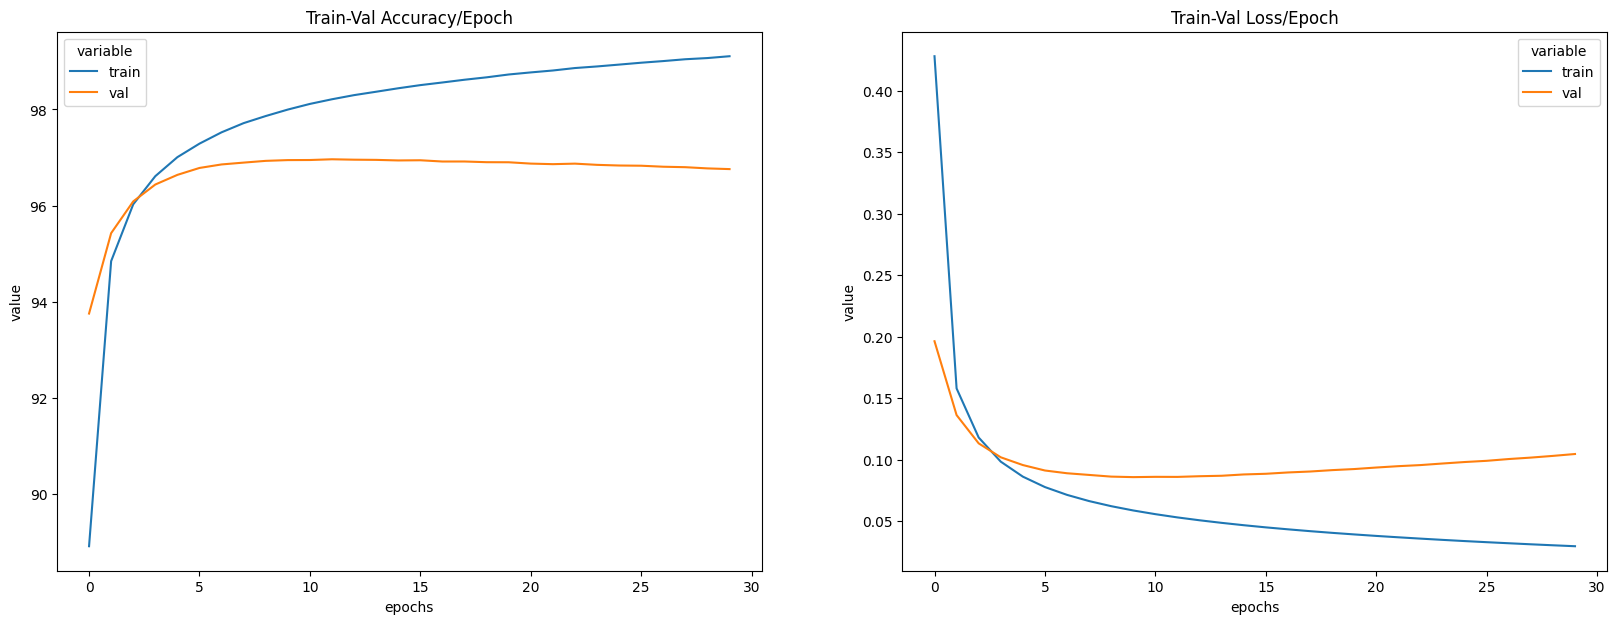

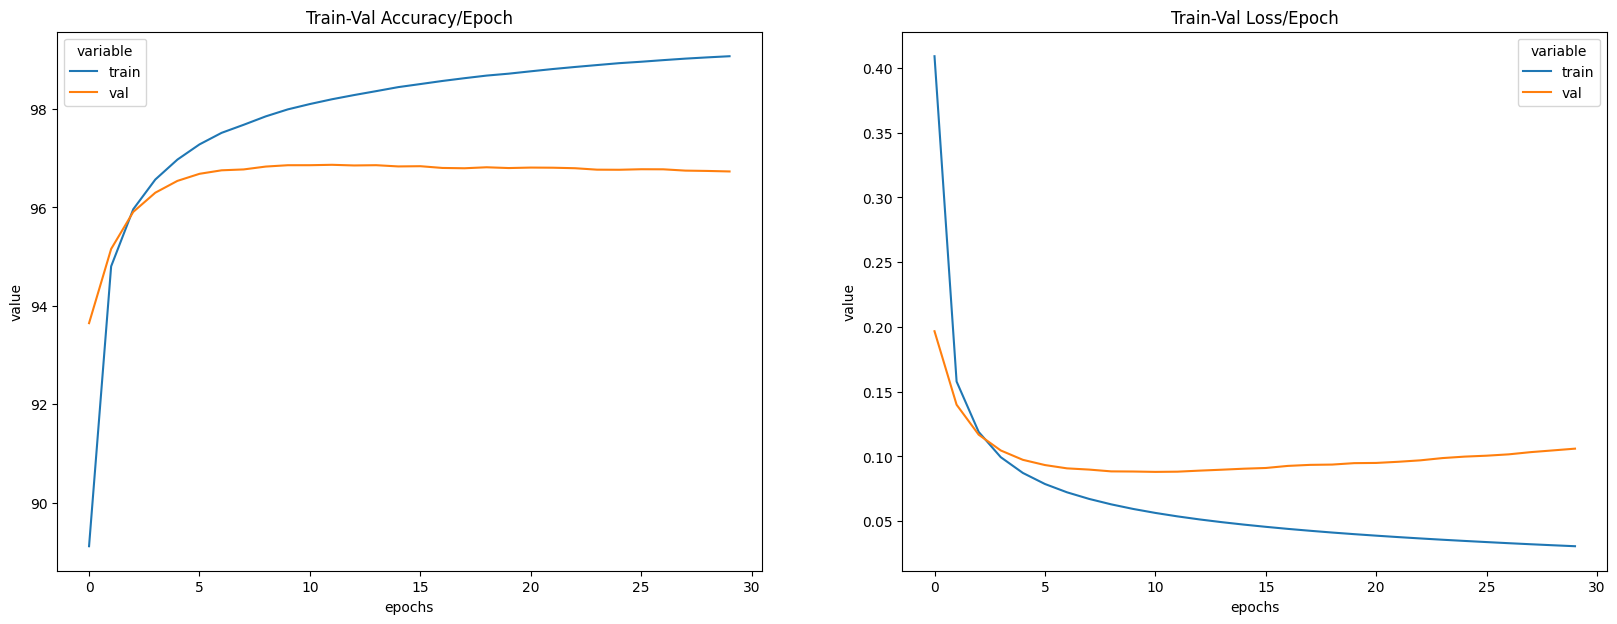

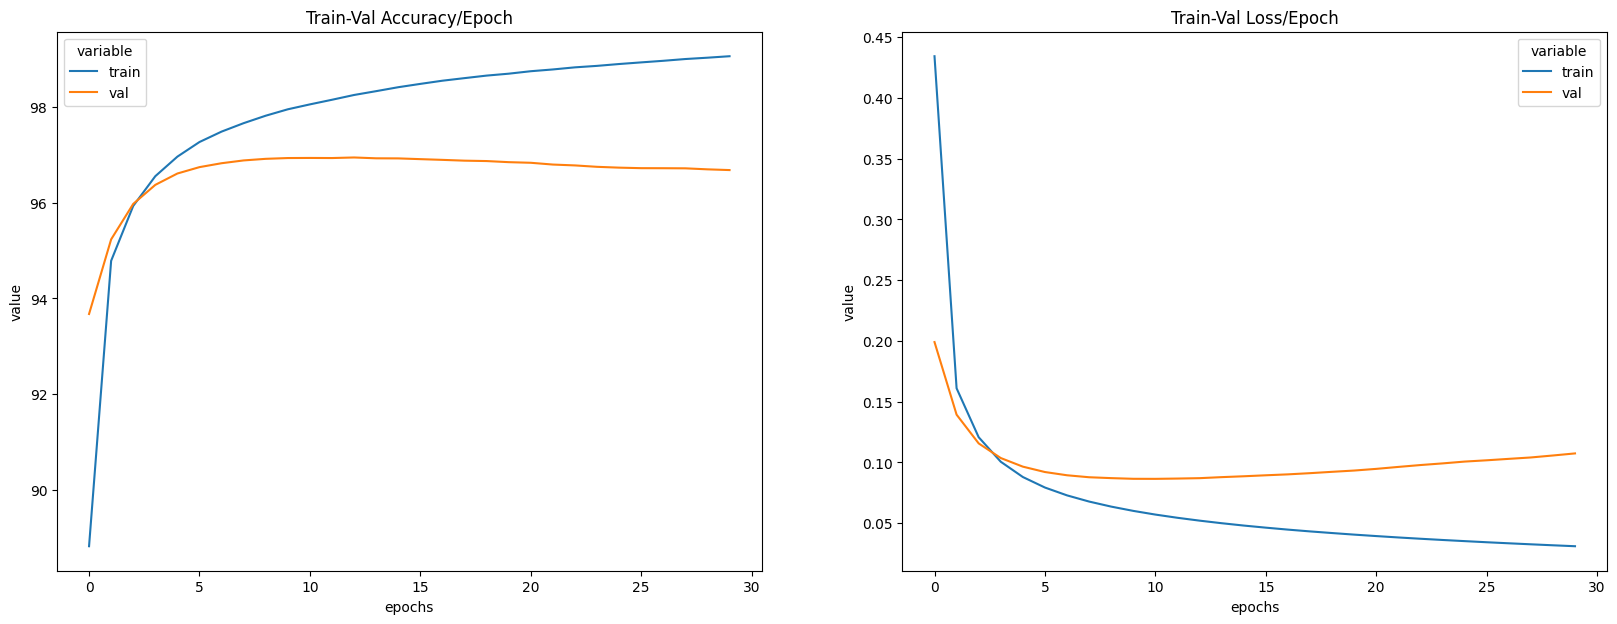

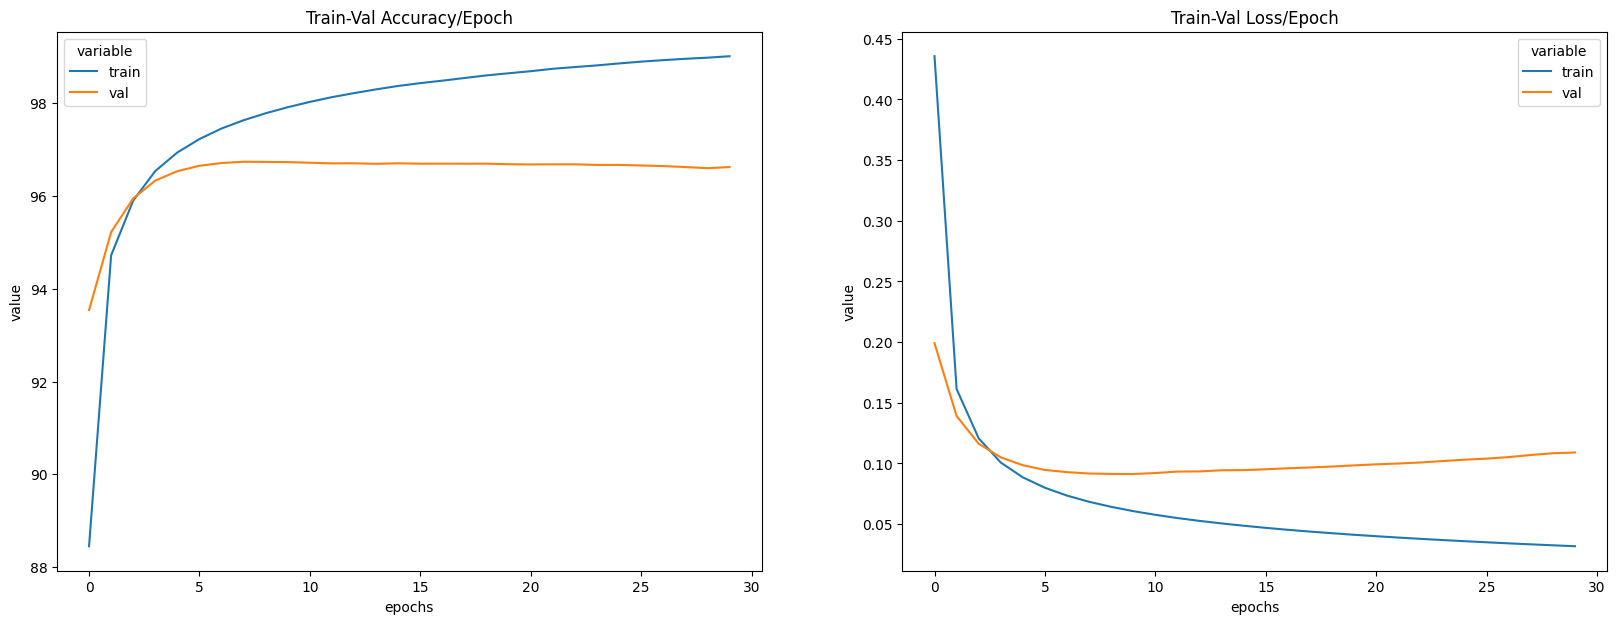

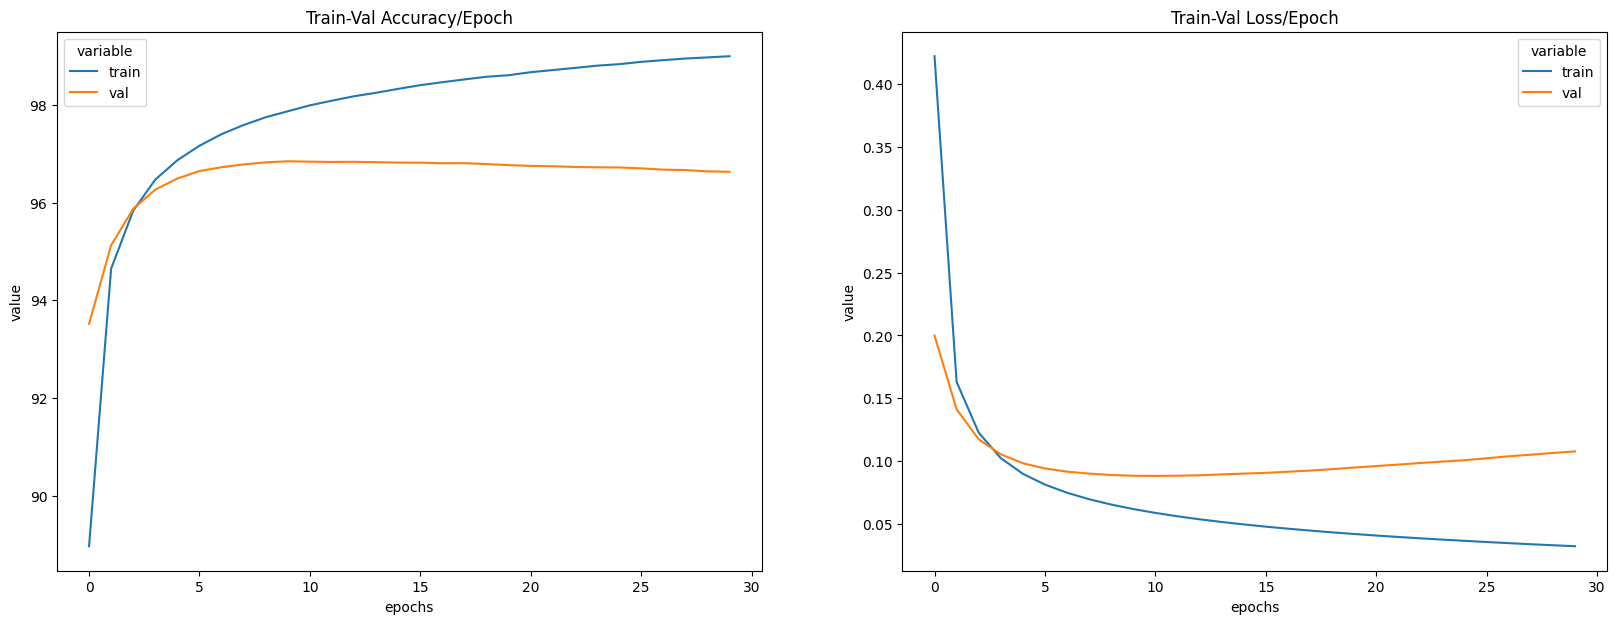

In [12]:
val_accuracies = []
val_avg = []

for i in range(n_splits):
    print(f"Split {i}...")
    df = adata.obs[[f'split{i}', patient]].drop_duplicates()
    train = list(df[df[f'split{i}'] == 'train'][patient])
    test = list(df[df[f'split{i}'] == 'val'][patient])
    x = pd.DataFrame(adata[adata.obs[patient].isin(train)].X.A).to_numpy()
    
    
    y = adata[adata.obs[patient].isin(train)].obs[condition].cat.rename_categories(list(range(NUM_CLASSES)))
    y = y.to_numpy()
    print(f'Train shape = ({x.shape}, {y.shape}).')

    x_test = pd.DataFrame(adata[adata.obs[patient].isin(test)].X.A).to_numpy()
    y_test = adata[adata.obs[patient].isin(test)].obs[condition].cat.rename_categories(list(range(NUM_CLASSES)))
    y_test = y_test.to_numpy()
    print(f'Val shape = ({x_test.shape}, {y_test.shape}).')

    cut = int(ceil(y.shape[0]*0.8))
    
    X_train = x[:cut]
    y_train = y[:cut]
    
    X_val = x[cut:]
    y_val = y[cut:]
    
    X_test = x_test
    y_test = y_test

    train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
    val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
    test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

    train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE)
    val_loader = DataLoader(dataset=val_dataset, batch_size=1)
    test_loader = DataLoader(dataset=test_dataset, batch_size=1)

    model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    accuracy_stats = {
        'train': [],
        "val": []
    }
    loss_stats = {
        'train': [],
        "val": []
    }

    print("Begin training.")
    for e in tqdm(range(1, EPOCHS+1)):
        
        # TRAINING
        train_epoch_loss = 0
        train_epoch_acc = 0
        model.train()
        for X_train_batch, y_train_batch in train_loader:
            X_train_batch, y_train_batch = X_train_batch, y_train_batch
            optimizer.zero_grad()
    
            y_train_pred = model(X_train_batch)
    
            train_loss = criterion(y_train_pred, y_train_batch)
            train_acc = multi_acc(y_train_pred, y_train_batch)
    
            train_loss.backward()
            optimizer.step()
    
            train_epoch_loss += train_loss.item()
            train_epoch_acc += train_acc.item()
            
            
        # VALIDATION    
        with torch.no_grad():
            
            val_epoch_loss = 0
            val_epoch_acc = 0
            
            model.eval()
            for X_val_batch, y_val_batch in val_loader:
                X_val_batch, y_val_batch = X_val_batch, y_val_batch
                
                y_val_pred = model(X_val_batch)
                            
                val_loss = criterion(y_val_pred, y_val_batch)
                val_acc = multi_acc(y_val_pred, y_val_batch)
                
                val_epoch_loss += val_loss.item()
                val_epoch_acc += val_acc.item()
                
        loss_stats['train'].append(train_epoch_loss/len(train_loader))
        loss_stats['val'].append(val_epoch_loss/len(val_loader))
        accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
        accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                                  
        
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')
    
    # Create dataframes
    train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
    train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
    # Plot the dataframes
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
    sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
    sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

    # predict
    y_pred_list = []
    with torch.no_grad():
        model.eval()
        for X_batch, _ in test_loader:
            X_batch = X_batch
            y_test_pred = model(X_batch)
            _, y_pred_tags = torch.max(y_test_pred, dim = 1)
            y_pred_list.append(y_pred_tags.cpu().numpy())
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    
    df = classification_report(y_test, y_pred_list, output_dict=True)
    df = pd.DataFrame(df).T
    print('class report')
    print(df)
    
    val_accuracies.append(df["f1-score"]["accuracy"])
    val_avg.append(df["f1-score"]["weighted avg"])
    
    print(f'Accuracy on the test set = {df["f1-score"]["accuracy"]}.')
    print('===========================')
    
print(f"Mean validation accuracy across 5 CV splits for a NN model = {np.mean(np.array(val_accuracies))}.")
print(f"Mean validation weighted avg across 5 CV splits for a NN model = {np.mean(np.array(val_avg))}.")


# Random forest

In [13]:
from sklearn.ensemble import RandomForestClassifier

In [14]:
adata.obs[condition] = adata.obs[condition].astype('category')
rename_dict = {name: number for number, name in enumerate(sorted(list(adata.obs[condition].cat.categories)))}
rename_dict

{'CF': 0,
 'COPD': 1,
 'COVID-19': 2,
 'Carcinoma': 3,
 'Chronic rhinitis': 4,
 'Healthy': 5,
 'ILD': 6,
 'IPF': 7,
 'Pneumonia non-COVID': 8}

In [15]:
val_accuracies = []
val_avg = []
for i in range(n_splits):
    print(f'Processing split = {i}...')
    #df = adata.obs[[f'split{i}', patient]].drop_duplicates()
    #train = list(df[df[f'split{i}'] == 'train'][patient])
    #val = list(df[df[f'split{i}'] == 'val'][patient])
    # train data
    x = pd.DataFrame(adata[adata.obs[f'split{i}'] == 'train'].X.A).to_numpy()
    num_of_classes = len(adata.obs[condition].cat.categories)
    y = adata[adata.obs[f'split{i}'] == 'train'].obs[condition].cat.rename_categories(rename_dict)
    y = y.to_numpy()
    print("Train shapes:")
    print(f"x.shape = {x.shape}")
    print(f"y.shape = {y.shape}")
    # val data
    x_val = pd.DataFrame(adata[adata.obs[f'split{i}'] == 'val'].X.A).to_numpy()
    y_val = adata[adata.obs[f'split{i}'] == 'val'].obs[condition].cat.rename_categories(rename_dict)
    y_val = y_val.to_numpy()
    print("Val shapes:")
    print(f"x_val.shape = {x_val.shape}")
    print(f"y_val.shape = {y_val.shape}")
    # fit
    X = x
    Y = y
    clf = RandomForestClassifier(n_estimators=5)
    clf.fit(X, Y)
    print(f'Train accuracy = {np.sum(clf.predict(X) == Y)/len(Y)}.')
    y_pred = clf.predict(x_val)
    val_accuracy = np.sum(y_pred == y_val)/len(y_val)
    
    df = classification_report(y_val, y_pred, output_dict=True)
    df = pd.DataFrame(df).T
    print('class report')
    print(df)
    
    val_accuracies.append(df["f1-score"]["accuracy"])
    val_avg.append(df["f1-score"]["weighted avg"])
    
    val_accuracy = df["f1-score"]["accuracy"]
    
    print(f'Val accuracy = {val_accuracy}.')
    print('===========================')


print(f"Mean validation accuracy across 5 CV splits for a random forest model = {np.mean(np.array(val_accuracies))}.")
print(f"Mean validation weighted avg across 5 CV splits for a random forest model = {np.mean(np.array(val_avg))}.")


Processing split = 0...
Train shapes:
x.shape = (1733726, 2000)
y.shape = (1733726,)
Val shapes:
x_val.shape = (415958, 2000)
y_val.shape = (415958,)
Train accuracy = 0.9853898482228449.
class report
              precision    recall  f1-score        support
0              0.246479  0.213849  0.229008     982.000000
1              0.582457  0.370204  0.452685   24681.000000
2              0.732989  0.832651  0.779648   36134.000000
3              0.546143  0.668745  0.601258   11867.000000
4              0.926213  0.752548  0.830398    6672.000000
5              0.782821  0.921612  0.846566  243457.000000
6              0.175581  0.213564  0.192719    8316.000000
7              0.724523  0.373302  0.492730   78979.000000
8              0.510595  0.103901  0.172667    4870.000000
accuracy       0.741731  0.741731  0.741731       0.741731
macro avg      0.580867  0.494486  0.510853  415958.000000
weighted avg   0.734488  0.741731  0.720520  415958.000000
Val accuracy = 0.7417311363166473